In [ ]:
# Download von diversen Zeitkategorien von DB Rad+ API
# Zur Erstellung des Codes wurde die generative Künstliche Intelligenz (KI) „Claude AI“ des Anbieters Anthropic in Version 3.7 genutzt

In [2]:
# Skript holt einen oder mehrere Datensätze vom API ohne Prozessierung

from requests import post, get
import pandas as pd
import geopandas as gpd

from shapely.geometry import Point, LineString

import json

In [3]:
# set crendetials

In [4]:
# Lade die Zugangsdaten aus der JSON-Datei
with open('credentials.json') as json_file:
    credentials = json.load(json_file)

# Hole die E-Mail und das Passwort aus dem JSON-Dictionary
user = credentials['email']
password = credentials['password']

In [5]:
city = "B" # how to get this? -> check get_data_from_api

api_url = "https://geoapi-radplus.bahnhof.de/api"
#api_url = "http://localhost:8000/api"
proxies = {} # enter your proxies

In [6]:
# load some useful defs

In [7]:
def get_token(user, password):
    r = post(
        api_url + "/token",
        headers={'accept': 'application/json'},
        data={"username": user,  "password": password})
    if r.status_code == 200:
        return r.json()['access_token']
    print("Fehler: ", r.reason)
    return False


def do_post(token, url, json):
    r = post(
        url,
        headers={'accept': 'application/json',
                 'Authorization': 'Bearer '+token},
        json=json, proxies=proxies)
    if r.status_code == 200:
        return r
    print("Fehler: ", r.reason)
    return False


def do_get(token, url):
    r = get(
        url,
        headers={'accept': 'application/json',
                 'Authorization': 'Bearer '+token},
        proxies=proxies)
    if r.status_code == 200:
        return r
    print("Fehler: ", r.reason)
    return False


def get_types(token):
    r = do_get(
        token, api_url + '/segment/types/' + city)
    if r == False:
        return False
    return r.json()


def get_segments(token, json={}, filename=None):
    r = do_post(
        token, api_url + '/segments/' + city, json=json)
    if r == False:
        return False
    if filename is not None:
        with open(filename, 'w') as f:
            f.write(r.text)
    return r.json()


def get_nodes(token, json={}, filename=None):
    r = do_post(
        token, api_url + '/nodes/' + city, json=json)
    if r == False:
        return False
    if filename is not None:
        with open(filename, 'w') as f:
            f.write(r.text)
    return r.json()


def get_flows(token, json={}, filename=None):
    r = do_post(
        token, api_url + '/flows/' + city, json=json)
    if r == False:
        return False
    if filename is not None:
        with open(filename, 'w') as f:
            f.write(r.text)
    return r.json()


token = get_token(user, password)

In [ ]:
# WITHOUT RETRY

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString

# Function to process and export segment data
def process_segments(input_jsons, filenames):
    for idx, (input_json, filename) in enumerate(zip(input_jsons, filenames)):
        # Fetch data from API
        segments = get_segments(token, input_json)  # Use pre-defined token

        # Check if data is retrieved
        if not segments or 'features' not in segments:
            print(f"Failed to retrieve data for request {idx + 1}")
            continue

        # Convert features to DataFrame
        df = pd.DataFrame(segments['features'])

        # Explode dictionaries in the DataFrame
        gdf = gpd.GeoDataFrame(explodeDictsInDF(df), geometry="geometry")

        # Remove the 'properties' column
        if 'properties' in gdf.columns:
            gdf.drop(columns=['properties'], inplace=True)

        # Set CRS for geospatial data, reproject if necessary
        if gdf.crs is None:
            gdf.set_crs("EPSG:25833", inplace=True)

        # Export to GeoPackage
        gdf.to_file(filename, driver="GPKG")
        print(f"Exported: {filename}")

# Function to handle nested dictionaries
def explodeDictsInDF(df_):
    df = df_.copy()
    for ind, row in df.iterrows():
        # Extract properties
        props = row['properties']
        for key, value in props.items():
            df.at[ind, key] = str(value) if key == "speeds" else value

        # Extract geometry
        geoms = row['geometry']
        geom_type = geoms.get("type")
        if geom_type == "LineString":
            geometry_built = LineString(geoms.get("coordinates"))
            df.at[ind, "geometry"] = geometry_built

    return df

In [8]:
# WITH RETRY, KEEP EPSG

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import requests

# Function to create a retry-enabled session
def create_retry_session(retries=30, backoff_factor=2.0, status_forcelist=(500, 502, 503, 504)):
    session = requests.Session()
    retry = Retry(
        total=retries,
        read=retries,
        connect=retries,
        backoff_factor=backoff_factor,
        status_forcelist=status_forcelist,
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount("https://", adapter)
    session.mount("http://", adapter)
    return session

# Function to fetch data from API with retries
def get_segments_with_retry(token, input_json, retries=30):
    session = create_retry_session(retries=retries)
    url = 'https://geoapi-radplus.bahnhof.de/api/segments/B'
    headers = {"Authorization": f"Bearer {token}"}
    
    try:
        response = session.post(url, json=input_json, headers=headers, timeout=60)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Request failed after {retries} retries: {e}")
        return None

# Function to process and export segment data
def process_segments(input_jsons, filenames):
    for idx, (input_json, filename) in enumerate(zip(input_jsons, filenames)):
        # Fetch data from API with retry logic
        segments = get_segments_with_retry(token, input_json)

        # Check if data is retrieved
        if not segments or 'features' not in segments:
            print(f"Failed to retrieve data for request {idx + 1}")
            continue

        # Convert features to DataFrame
        df = pd.DataFrame(segments['features'])

        # Explode dictionaries in the DataFrame
        gdf = gpd.GeoDataFrame(explodeDictsInDF(df), geometry="geometry")

        # Remove the 'properties' column
        if 'properties' in gdf.columns:
            gdf.drop(columns=['properties'], inplace=True)

        # Set CRS for geospatial data, reproject if necessary
        if gdf.crs is None:
            gdf.set_crs("EPSG:4326", inplace=True)  # Assuming WGS84

        # Export to GeoPackage
        gdf.to_file(filename, driver="GPKG")
        print(f"Exported: {filename}")

# Function to handle nested dictionaries
def explodeDictsInDF(df_):
    df = df_.copy()
    for ind, row in df.iterrows():
        # Extract properties
        props = row['properties']
        for key, value in props.items():
            df.at[ind, key] = str(value) if key == "speeds" else value

        # Extract geometry
        geoms = row['geometry']
        geom_type = geoms.get("type")
        if geom_type == "LineString":
            geometry_built = LineString(geoms.get("coordinates"))
            df.at[ind, "geometry"] = geometry_built

    return df

In [ ]:
# CopyPaste Vorlage für Abfrage

input_json = {
    "date_from": "2024-03-01",
    "date_to": "2024-03-03",
    # "access_type": "private",
    # "segment_type": ['residential', 'track', 'path'],
    # "day_of_week": [0, 1, 2, 3, 4, 5, 6],
    # "hour_of_day": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
}

#print(get_types(token))
#print(get_segments(token, json) )

In [8]:
# Template, um mehrere Datensätze nacheinander herunterzuladen und zu speichern
input_jsons = [
    {'date_from': '2023-04-01', 'date_to': '2023-04-30'},
    {'date_from': '2023-05-01', 'date_to': '2023-05-31'},
    {'date_from': '2023-06-01', 'date_to': '2023-06-30'},
    {'date_from': '2023-07-01', 'date_to': '2023-07-31'},
    {'date_from': '2023-08-01', 'date_to': '2023-08-31'},
    {'date_from': '2023-09-01', 'date_to': '2023-09-30'},
    {'date_from': '2023-10-01', 'date_to': '2023-10-31'},
    {'date_from': '2023-11-01', 'date_to': '2023-11-30'},
    {'date_from': '2023-12-01', 'date_to': '2023-12-31'},
    {'date_from': '2024-01-01', 'date_to': '2024-01-31'}
]

filenames = [
    'data/23-04_all_4326.gpkg',
    'data/23-05_all_4326.gpkg',
    'data/23-06_all_4326.gpkg',
    'data/23-07_all_4326.gpkg',
    'data/23-08_all_4326.gpkg',
    'data/23-09_all_4326.gpkg',
    'data/23-10_all_4326.gpkg',
    'data/23-11_all_4326.gpkg',
    'data/23-12_all_4326.gpkg',
    'data/24-01_all_4326.gpkg'
]

process_segments(input_jsons, filenames)

Exported: data/23-04_all_4326.gpkg
Exported: data/23-05_all_4326.gpkg
Exported: data/23-06_all_4326.gpkg
Exported: data/23-07_all_4326.gpkg
Exported: data/23-08_all_4326.gpkg
Exported: data/23-09_all_4326.gpkg
Exported: data/23-10_all_4326.gpkg
Exported: data/23-11_all_4326.gpkg
Exported: data/23-12_all_4326.gpkg
Exported: data/24-01_all_4326.gpkg


In [ ]:
# Template für einen Datensatz
input_jsons = [
    {'date_from': '2023-04-17', 'date_to': '2024-12-31'}
]

filenames = [
    'data/230417-241231_all.gpkg'
]

process_segments(input_jsons, filenames)

In [12]:
# Template für Abfrage von Tag, Nacht, Rushhour, Wochentag, Wochenende etc. je Monat

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import os

def generate_dataset_params(start_year, start_month, end_year, end_month):
    categories = {
   'weekday': {
       'day_of_week': [0, 1, 2, 3, 4],
       'suffix': 'weekday'
   },
   'weekend': {
       'day_of_week': [5, 6],
       'suffix': 'weekend'
   },
   'rush_morning': {
       'day_of_week': [0, 1, 2, 3, 4],
       'hour_of_day': [6, 7, 8, 9],  # 06:00-09:59
       'suffix': 'rush_am'
   },
   'rush_evening': {
       'day_of_week': [0, 1, 2, 3, 4],
       'hour_of_day': [15, 16, 17, 18],  # 15:00-18:59
       'suffix': 'rush_pm'
   },
   'rush_combined': {
       'day_of_week': [0, 1, 2, 3, 4],
       'hour_of_day': [6, 7, 8, 9, 15, 16, 17, 18],
       'suffix': 'rush_combined'
   },
   'weekday_day': {
       'day_of_week': [0, 1, 2, 3, 4],
       'hour_of_day': list(range(6, 22)),  # 06:00-21:59
       'suffix': 'weekday_day'
   },
   'weekday_night': {
       'day_of_week': [0, 1, 2, 3, 4],
       'hour_of_day': list(range(0, 6)) + list(range(22, 24)),  # 22:00-05:59
       'suffix': 'weekday_night'
   },
   'weekend_day': {
       'day_of_week': [5, 6],
       'hour_of_day': list(range(6, 22)),  # 06:00-21:59
       'suffix': 'weekend_day'
   },
   'weekend_night': {
       'day_of_week': [5, 6],
       'hour_of_day': list(range(0, 6)) + list(range(22, 24)),  # 22:00-05:59
       'suffix': 'weekend_night'
   }
}
    
    input_jsons = []
    filenames = []
    
    start_date = datetime(start_year, start_month, 1)
    end_date = datetime(end_year, end_month, 1) + relativedelta(months=1) - timedelta(days=1)
    current_date = start_date
    
    while current_date <= end_date:
        next_date = current_date + relativedelta(months=1) - timedelta(days=1)
        
        for category, params in categories.items():
            json_params = {
                'date_from': current_date.strftime('%Y-%m-%d'),
                'date_to': next_date.strftime('%Y-%m-%d'),
                'day_of_week': params['day_of_week']
            }
            
            if 'hour_of_day' in params:
                json_params['hour_of_day'] = params['hour_of_day']
            
            month_str = current_date.strftime('%y-%m')
            filename = f'data/{month_str}_{params["suffix"]}.gpkg'
            
            input_jsons.append(json_params)
            filenames.append(filename)
        
        current_date += relativedelta(months=1)
    
    return input_jsons, filenames

# Generate parameters for 2023 (April to December)
input_jsons_2023, filenames_2023 = generate_dataset_params(2023, 7, 2023, 12)

# Generate parameters for 2024 (full year)
input_jsons_2024, filenames_2024 = generate_dataset_params(2024, 1, 2024, 12)

# Combine both periods
input_jsons = input_jsons_2024 + input_jsons_2023
filenames =  filenames_2024 + filenames_2023

# Process all datasets using the predefined function
print("Starting data processing...")
process_segments(input_jsons, filenames)
print("Processing completed!")

Starting data processing...
Exported: data/24-01_weekday.gpkg
Exported: data/24-01_weekend.gpkg
Exported: data/24-01_rush_am.gpkg
Exported: data/24-01_rush_pm.gpkg
Exported: data/24-01_rush_combined.gpkg
Exported: data/24-01_weekday_day.gpkg
Exported: data/24-01_weekday_night.gpkg
Exported: data/24-01_weekend_day.gpkg
Exported: data/24-01_weekend_night.gpkg
Exported: data/24-02_weekday.gpkg
Exported: data/24-02_weekend.gpkg
Exported: data/24-02_rush_am.gpkg
Exported: data/24-02_rush_pm.gpkg
Exported: data/24-02_rush_combined.gpkg
Exported: data/24-02_weekday_day.gpkg
Exported: data/24-02_weekday_night.gpkg
Exported: data/24-02_weekend_day.gpkg
Exported: data/24-02_weekend_night.gpkg
Exported: data/24-03_weekday.gpkg
Exported: data/24-03_weekend.gpkg
Exported: data/24-03_rush_am.gpkg
Exported: data/24-03_rush_pm.gpkg
Exported: data/24-03_rush_combined.gpkg
Exported: data/24-03_weekday_day.gpkg
Exported: data/24-03_weekday_night.gpkg
Exported: data/24-03_weekend_day.gpkg
Exported: data/2

Number of features: 10101


<Axes: >

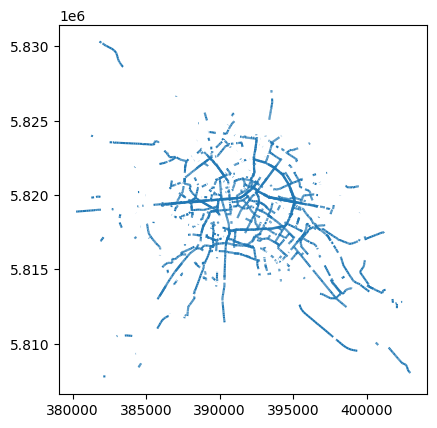

In [8]:
# Plot / Explore a Dataset

import geopandas as gpd
import pyogrio
import matplotlib.pyplot as plt
import seaborn as sns

# Read and transform data
gdf = pyogrio.read_dataframe("data/23-06_weekend_night.gpkg", use_arrow=True)
gdf = gdf.to_crs('EPSG:4326')

#Print Number of features
print(f"Number of features: {len(gdf)}")

# Map
gdf.plot()

#explore
#gdf.explore()

In [20]:
from datetime import datetime

def generate_dataset_params():
    categories = {
        'weekday': {'day_of_week': [0, 1, 2, 3, 4], 'suffix': 'weekday'},
        'weekend': {'day_of_week': [5, 6], 'suffix': 'weekend'},
        'rush_am': {'day_of_week': [0, 1, 2, 3, 4], 'hour_of_day': [6, 7, 8, 9], 'suffix': 'rush_am'},
        'rush_pm': {'day_of_week': [0, 1, 2, 3, 4], 'hour_of_day': [15, 16, 17, 18], 'suffix': 'rush_pm'},
        'rush_combined': {'day_of_week': [0, 1, 2, 3, 4], 'hour_of_day': [6, 7, 8, 9, 15, 16, 17, 18], 'suffix': 'rush_combined'},
        'weekday_day': {'day_of_week': [0, 1, 2, 3, 4], 'hour_of_day': list(range(6, 22)), 'suffix': 'weekday_day'},
        'weekday_night': {'day_of_week': [0, 1, 2, 3, 4], 'hour_of_day': list(range(0, 6)) + list(range(22, 24)), 'suffix': 'weekday_night'},
        'weekend_day': {'day_of_week': [5, 6], 'hour_of_day': list(range(6, 22)), 'suffix': 'weekend_day'},
        'weekend_night': {'day_of_week': [5, 6], 'hour_of_day': list(range(0, 6)) + list(range(22, 24)), 'suffix': 'weekend_night'}
    }
    
    input_jsons = []
    filenames = []
    
    start_date = datetime(2024, 10, 1)
    end_date = datetime(2024, 12, 31)
    
    for category, params in categories.items():
        json_params = {
            'date_from': start_date.strftime('%Y-%m-%d'),
            'date_to': end_date.strftime('%Y-%m-%d'),
            'day_of_week': params['day_of_week']
        }
        if 'hour_of_day' in params:
            json_params['hour_of_day'] = params['hour_of_day']
        
        filename = f'data/24-10-12_{params["suffix"]}.gpkg'
        
        input_jsons.append(json_params)
        filenames.append(filename)
    
    return input_jsons, filenames

print("Processing October-December 2024...")
input_jsons, filenames = generate_dataset_params()
process_segments(input_jsons, filenames)
print("Processing completed!")

Processing October-December 2024...
Exported: data/24-10-12_weekday.gpkg
Exported: data/24-10-12_weekend.gpkg
Exported: data/24-10-12_rush_am.gpkg
Exported: data/24-10-12_rush_pm.gpkg
Exported: data/24-10-12_rush_combined.gpkg
Exported: data/24-10-12_weekday_day.gpkg
Exported: data/24-10-12_weekday_night.gpkg
Exported: data/24-10-12_weekend_day.gpkg
Exported: data/24-10-12_weekend_night.gpkg
Processing completed!
